In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
sys.path.append('../src/')

from simulator import Simulator

from savgol.utils import savgol_filter
from savgol.utils import asymmetric_least_squares
from savgol.utils import durbin_watson_criterion
from savgol.utils import find_peaks

In [23]:
simulator = Simulator(
    resolution=16384,
    num_peaks_range=(5, 50),
    snr_range=(15.0, 45.0),
    amplitude_range=(50, 250),
    loc_range=(0.05, 0.95),
    scale_range=(0.001, 0.003),
    asymmetry_range=(-0.15, 0.15),
    noise_type='white',
)

In [24]:
# scale array
def scale(list):
    s = []
    m = max(list)
    for i in list:
        s.append(i/m)
    return s
   
# Finding local minima in second derivative
# will be position of peak appex
def local_min(func,thresh):
    minima = []
    for i in range(len(func)-7):
        if func[i+4] < func[i] and func[i+4] < func[i+1] and func[i+4] < func[i+2] and func[i+4] < func[i+3]  and func[i+4] < func[i+5] and func[i+4] < func[i+6] and func[i+4] < func[i+7] and func[i+4] < -thresh:
            minima.append(i+4)
    return minima

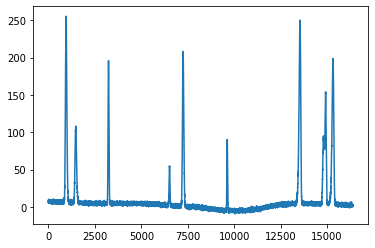

In [48]:
data = simulator._generate(4)

x = data['chromatogram']
plt.plot(x)

In [49]:
def search_savgol_params(x, params):
    best_val = float('inf')
    for order in params['polyorder']:
        for window in params['window_length']:
            
            z = savgol_filter(x, window, order)
            val = durbin_watson_criterion(x, z)
            if abs(val - 2.) < abs(best_val - 2.):
                best_val = val
                best_param = {'window_length': window, 'polyorder': order}
                
    return best_param


param = search_savgol_params(x, {'window_length': range(5, 301, 2), 'polyorder': [2]})

# NOTICE: current durbin-watson criterion does not work well for detecting peaks. 
#         the best params are smoothening to little!

print(param)

{'window_length': 37, 'polyorder': 2}


10
[951, 1468, 3235, 6519, 7249, 9627, 13549, 14799, 14926, 15323]
10
[951, 1470, 3235, 6519, 7250, 9627, 13544, 14812, 14925, 15320]


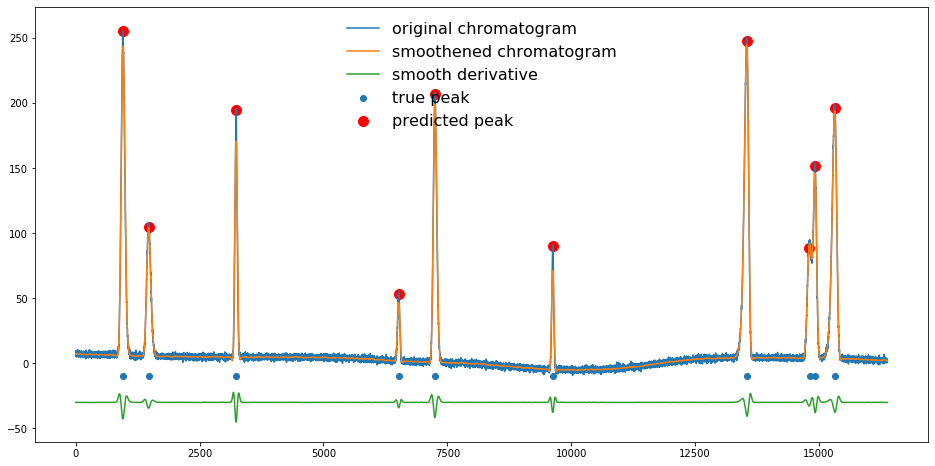

In [50]:
plt.figure(figsize=(16, 8))

# Lets use big window size for better peak detection
x_smooth, x_deriv = savgol_filter(x, window_length=101, deriv=2)

# Finding peaks with in-house code 
loc = local_min(scale(x_deriv),0.05)

# Find peaks by finding the local minima in the second derivative
#loc = find_peaks(x_deriv, height=0.001, distance=30)
print(len(loc))
print(loc)

# Plot out stuff
plt.plot(x, label='original chromatogram')
plt.plot(x_smooth, label='smoothened chromatogram')
plt.scatter(data['loc']*len(x), [-10.]*len(data['loc']), label='true peak')
p = (data['loc']*len(x)).tolist()
p.sort()
peaks = []
for i in p:
    peaks.append(int(i))
print(len(peaks))
print(peaks)
plt.scatter(loc, x[loc], color='red', s=100, label='predicted peak')

# plot out derivative. multiplied by 100 to increase the magnitude, 
# and subtract it to move it down. only for visualization purposes
plt.plot(x_deriv * 100 - 30, label='smooth derivative')
plt.legend(fontsize=16, frameon=False);
